## Training on rural dataset

Given the water/vegetation labelling, there is 3 classes (including background).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import random
import json
import numpy as np
from datetime import datetime
from PIL import Image, ImageOps
from PIL.ImagePalette import ImagePalette
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

# local python files:
from deeplab.model import Deeplabv3
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # necessary to access semantic_utils.py
import semantic_utils

In [3]:
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data")

train_input_dir = os.path.join(DATA_DIR, 'train')
train_target_dir = os.path.join(DATA_DIR, 'train_class_images')
val_input_dir = os.path.join(DATA_DIR, 'val')
val_target_dir = os.path.join(DATA_DIR, 'val_class_images')


def get_img_paths(directory):
    return sorted([
        os.path.join(directory, fname)
        for fname in os.listdir(directory)
        if fname.endswith(".jpeg")
    ])


train_input_img_paths = get_img_paths(train_input_dir)
train_target_img_paths = get_img_paths(train_target_dir)
val_input_img_paths = get_img_paths(val_input_dir)
val_target_img_paths = get_img_paths(val_target_dir)

In [4]:
print(f"Number of train images: {len(train_input_img_paths)}")
print(f"Number of val images:   {len(val_input_img_paths)}")

Number of train images: 1258
Number of val images:   314


In [5]:
# Prepare Sequence class to load & vectorise batches of data
class WaterVegetation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
#         y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2) # Ground truth labels are 0, 1, 2
        return x, y

In [6]:
# Instantiate data Sequences for each split
batch_size = 2
img_size = (512, 512)
train_gen = WaterVegetation(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = WaterVegetation(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [7]:
# clear previous models from RAM
keras.backend.clear_session()

# create and compile model
NUM_CLASSES = 3
custom_model = Deeplabv3(input_shape=list(img_size) + [3], classes=4,
                         weights=None, backbone='mobilenetv2', activation='softmax')

LEARNING_RATE = 0.001
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# opt = keras.optimizers.SGD(learning_rate=LEARNING_RATE)
custom_model.compile(
    optimizer=opt, 
    loss="sparse_categorical_crossentropy"
)

In [8]:
weight_decay = 0.01
for layer in custom_model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = keras.regularizers.l2(weight_decay)

In [ ]:
# Train the model, doing validation at the end of each epoch
NUM_EPOCHS = 5
STEPS_PER_EPOCH = len(train_gen.target_img_paths) // batch_size

now = datetime.now().strftime("%Y%m%dT%H%M")

log_dir = os.path.join(ROOT_DIR, "KERAS_DEEPLAB", "logs")
checkpoint_path = os.path.join(log_dir, now)

print(f"Logs directory: {log_dir}")
print(f"Checkpoints path: {checkpoint_path}")

callbacks = [
    keras.callbacks.TensorBoard(log_dir=checkpoint_path),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                    save_best_only=True)
]

history = custom_model.fit(
    train_gen, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_gen,
    callbacks=callbacks
);

In [9]:
# Load model from file
LOAD_MODEL_DIR = os.path.join(os.getcwd(), "logs", "20210223T1722")
print(f"Model being loaded from: {LOAD_MODEL_DIR}")
loaded_model = keras.models.load_model(LOAD_MODEL_DIR)

Model being loaded from: /home/ucsail/rural_images/KERAS_DEEPLAB/logs/20210223T1722


In [10]:
# Generate predictions for all images in the validation set
val_preds = custom_model.predict(val_gen)

# input_tensor = tf.convert_to_tensor(val_gen)
# output_tensor = loaded_model(input_tensor)
# val_preds = output_tensor.numpy()

In [11]:
# For each pixel, get label with the largest score
val_pred_labels = np.argmax(val_preds.squeeze(), axis=-1)

Predicted classes: [0]


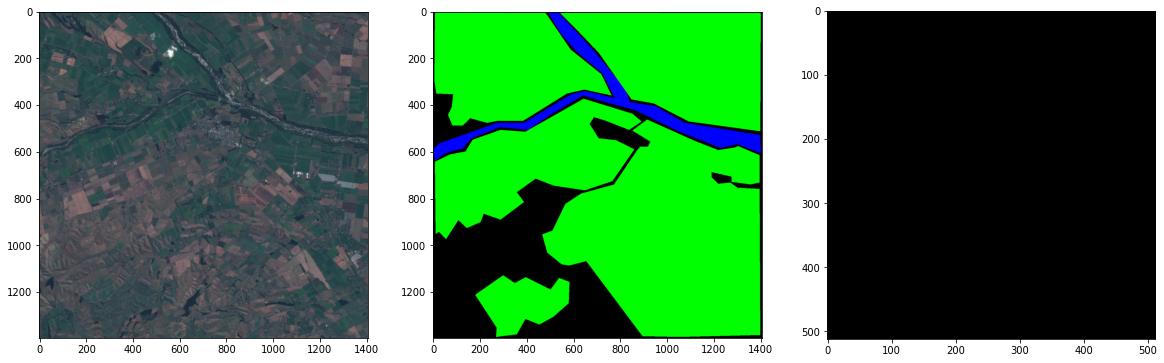

Predicted classes: [0]


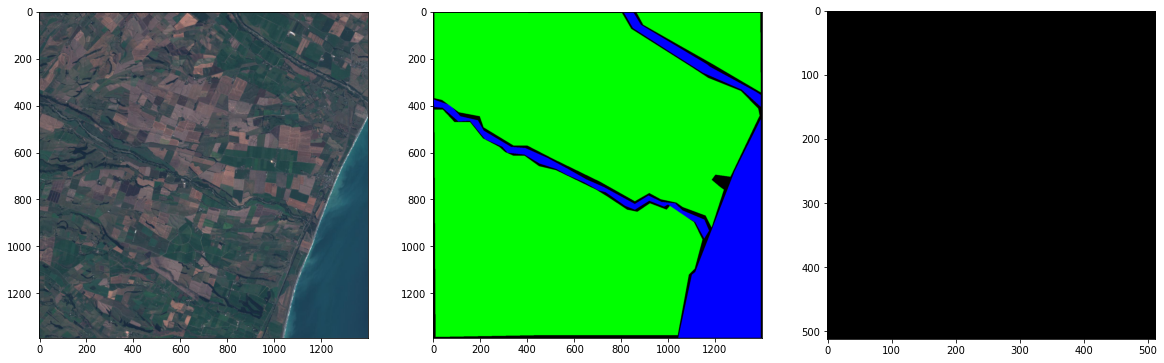

In [12]:
def display_masks(i, converter):
    """Quick utility to display an original image with it's corresponding labels and model prediction."""
    # Display input image
    fig, ax = plt.subplots(1, 3, figsize=(20,60))
    
    true_colour_img = Image.open(val_input_img_paths[i])
    ax[0].imshow(true_colour_img)
    
    # Display ground-truth target mask
    target_int_img = np.array(Image.open(val_target_img_paths[i]))[:, :, 0]
    target_colour_img = semantic_utils.convert_to_rgb(target_int_img, converter)
    ax[1].imshow(target_colour_img)
    
    # Display prediction
    labels = val_pred_labels[i]
    print(f"Predicted classes: {np.unique(labels)}")
    predicted_mask = semantic_utils.convert_to_rgb(labels, converter)
    ax[2].imshow(predicted_mask)
    
    plt.show()
        
    
water_vege_converter = {
    1: (0, 0, 255),  # water
    2: (0, 255, 0)   # vegetation
}
# Display mask predicted by our model
for i in range(120, 122):
    display_masks(i, water_vege_converter)  # Note that the model sees the image at a smaller resolution

# Evaluation

In [13]:
results = semantic_utils.compute_metrics(val_gen.target_img_paths, val_pred_labels, NUM_CLASSES, img_size[0], display=True)

All classes  |   mIOU: 0.4412   mF1 score: 0.4592
             |
Class 0      |    IOU: 0.5216    F1 score: 0.5841
Class 1      |    IOU: 0.0000    F1 score: 0.0000
Class 2      |    IOU: 0.0000    F1 score: 0.0000

Overall confusion matrix:
[[42938298        0        0]
 [11715070        0        0]
 [27659848        0        0]]

(rows=actual, cols=pred)


/home/ucsail/rural_images/KERAS_DEEPLAB/../semantic_utils.py:163: RuntimeWarning: invalid value encountered in true_divide
  intersections / unions,
/home/ucsail/rural_images/KERAS_DEEPLAB/../semantic_utils.py:166: RuntimeWarning: invalid value encountered in true_divide
  2 * intersections / (unions + intersections),


In [14]:
semantic_utils.print_metric_results(results, NUM_CLASSES)

All classes  |   mIOU: 0.4412   mF1 score: 0.4592
             |
Class 0      |    IOU: 0.5216    F1 score: 0.5841
Class 1      |    IOU: 0.0000    F1 score: 0.0000
Class 2      |    IOU: 0.0000    F1 score: 0.0000

Overall confusion matrix:
[[42938298        0        0]
 [11715070        0        0]
 [27659848        0        0]]

(rows=actual, cols=pred)
